# **Type III Solar Radio Burst Analysis Tool Tutorial**
**SOLER WP2 Radio Data Analysis Methods**

**Overview:** In three parts we’ll cover:

1. **Part 1: NenuFAR & Dynamic Spectra**  
   Introduction to the NenuFAR telescope and solar Type III radio bursts.
   Loading and reading NenuFAR dynamic‐spectrum data.

2. **Part 2: Defining Regions of Interest (ROI) for Type III Bursts**  
   Selecting the ROI around a chosen Type III burst.

3. **Part 3: Burst Time‐Profile Analysis & Exciter Velocity Determination**  
   Detailed burst analysis: fitting the time‐profile and deriving the exciter (electron beam) velocity.
---

**Developed by:** Jinge ZHANG, Paris Observatory (Meudon Site)

**My e-mail::** Jinge.Zhang@obspm.fr

---
---


## **Part 0: Before we start:**

### **0.1 Setting Up the Environment**
Before running this notebook, ensure running **Python 3.12 kernel**, and the required dependencies are installed.

If you are running this Jupyter notebook on your own computer, run the cell in step 0.3, and install all repuired packages been reported.



### **0.2 Matplotlib Inline Mode**

To display plots directly in the notebook, we use the following magic command:

In [1]:
%matplotlib inline

### **0.3 Import Required Libraries and Tools**

These are the core libraries and our Type III‐burst analysis tools.
Run this cell first to make everything available.

In [2]:
import os
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, num2date, date2num
import numpy as np
from datetime import datetime
import astropy.units as u


# These are the tools that developed for analysing type III bursts.

# from T3BurstTool_tutorial.combine_spectra import combine_spectra
# # Note: We are not importing `combine_spectra` in this tutorial because it requires execution on the Nancep server and the installation of the Nenupy package.

from T3BurstTool_tutorial.combine_spectra  import load_combined_hdf5
from T3BurstTool_tutorial.T3_time_profile import fit_roi_time_profiles
from T3BurstTool_tutorial.analysis_velocity import analyze_burst_velocity
from T3BurstTool_tutorial.window_detection import detect_window

---
---

## **Part 1: NenuFAR & Dynamic Spectra**

### What is NenuFAR?
- **NenuFAR** = [New Extension in Nançay Upgrading LOFAR](https://nenufar.obs-nancay.fr/en/homepage-en/#en-presentation)  
- Low-frequency array (10–85 MHz) with superb sensitivity  

### Quick-look Dynamic Spectrum
- Visit the [NENU-SUN quick-look page](https://nenusun.obspm.fr/catalogue/calendar/)  
- Check the availability of NenuFAR solar data in the calendar  
- Examine different types of solar radio bursts—especially Type III bursts  
- Stokes I, Q, U, V quick-looks available  
- **CONTEXT** view includes data from other instruments when available  

### Data Products on the Nançay Server (`nenufar-tf`)
- Raw dynamic spectra delivered as `.spectra` files  
- High time- and frequency-resolution  
- Use the **nenupy** Python package to load and read `.spectra` files  
---


### **1.0 Combine Low/High‐Band Spectra & Generate Dynamic Spectra**

**This cell will _not_ run on SOLER Hub** because it requires access to the Nançay (calls “Nancep”) data archive.  
When you are on the Nançay server, you can use this routine to quickly locate your `.spectra` files by simply providing the date and time of interest.  

This cell calls our `combine_spectra` routine to:

1. **Date & Time Range**  
   - **Inputs**:  
     - `date` (YYYYMMDD) — observation date  
     - `tmin`, `tmax` — UTC start/end of the window to extract  
2. **Locate & Load**  
   - Fetch the low-band (`spec_idx=0`) and high-band (`spec_idx=1`) `.spectra` files from the NenuFAR archive.  
3. **Rebin**  
   - Time resolution (`rebin_dt`) and frequency resolution (`rebin_df`) to your desired sampling.  
4. **Time Selection**  
   - Restrict to only the interval between `tmin` and `tmax`.  
5. **(Optional) RFI Mitigation**  
   - `mitigate_rfi=True` applies sigma-clipping filters in both frequency and time.  
6. **Normalization**  
   - Sliding-window percentile normalization (bottom `normalization_threshold` of each 1 min block by default).  
   - Saves diagnostics to `<DATE>_<STOKES>_responses.npz` containing block times, response curves, and background masks.  
7. **Combine Bands & Write HDF5**  
   - Merges low/high into `…_<DATE>_<STOKES>_COM.hdf5`.
8. **Quick‐Look Plot**  
   - If `show_dySp=True`, immediately displays the dynamic spectrum with properly formatted UT time axis.


#### **Outputs**

- **Return value**: a list of HDF5 file paths, each containing:
  - `frequency` (MHz): 1D array under `.../COORDINATES/frequency`  
  - `time` (Julian Date): 1D array under `.../COORDINATES/time`  
  - `<STOKES>` (intensity): 2D dynamic spectrum array `(ntime × nchan)` under `.../BEAM_000/<STOKES>`  
**These `combined_h5` files are**:
  - `<DATE>_<STOKES>_0.hdf5` — low-band dynamic spectrum (from `*_0.spectra`)
  - `<DATE>_<STOKES>_1.hdf5` — high-band dynamic spectrum (from `*_1.spectra`)
  - `<DATE>_<STOKES>_COM.hdf5` — combined wide-band dynamic spectrum

- **Diagnostic `.npz`**: if normalization is enabled, you’ll find `<DATE>_<STOKES>_responses.npz` in the same `output_dir`, containing:
  - `window_times`   — array of block‐midpoint times (JD)  
  - `resp_min`       — per‐block minimum per channel  
  - `resp_percentX`  — per‐block Xth‐percentile per channel  
  - `freq`           — full frequency axis  
  - `background_mask`— Boolean mask of which pixels were deemed “background” in each block  


2025-06-15 20:20:01 | WARNING: AstropyDeprecationWarning: The truth value of a Quantity is ambiguous. In the future this will raise a ValueError.
📥 Writing /databf/nenufar-tf/LT11/2025/03/20250329_090700_20250329_145000_SUN_TRACKING/SUN_TRACKING_20250329_090735_0.spectra → /home/jzhang/SOLER tools/user_workshop_tutorial/saved_hdf5/20250329_I_0.hdf5
2025-06-15 20:20:01 | INFO: Reading /databf/nenufar-tf/LT11/2025/03/20250329_090700_20250329_145000_SUN_TRACKING/SUN_TRACKING_20250329_090735_0.spectra...
2025-06-15 20:20:01 | INFO: 	/databf/nenufar-tf/LT11/2025/03/20250329_090700_20250329_145000_SUN_TRACKING/SUN_TRACKING_20250329_090735_0.spectra has been correctly parsed.
2025-06-15 20:20:01 | INFO: Skipping missing data verification...
2025-06-15 20:20:01 | INFO: Computing time-frequency axes...
2025-06-15 20:20:01 | INFO: Re-organize data into Jones matrices...
2025-06-15 20:20:01 | INFO: 	Convert data to Dask array
2025-06-15 20:20:01 | INFO: 	Set bad values to NaN.


2025-06-15 20:20:01 | INFO: Data loaded.
2025-06-15 20:20:01 | INFO: Selecting times (between 2025-03-29T12:28:48.000 and 2025-03-29T12:46:04.000)...
2025-06-15 20:20:01 | INFO: 	49401 time samples selected.
2025-06-15 20:20:01 | INFO: Selecting frequencies (between 21.6796875 MHz and 59.1796875 MHz)...
2025-06-15 20:20:01 | INFO: 	6144 frequency samples selected.
2025-06-15 20:20:02 | INFO: Pipeline configuration:
	0 - Correct bandpass
	1 - Remove subband channels
	2 - Rebin in time
	3 - Rebin in frequency
	4 - Compute Stokes parameters
2025-06-15 20:20:02 | INFO: Correcting for bandpass...
2025-06-15 20:20:02 | INFO: Removing channels...
2025-06-15 20:20:02 | INFO: 	Channels [ 0  1 -1] set to NaN.
2025-06-15 20:20:02 | INFO: Rebinning in time...
2025-06-15 20:20:02 | INFO: 	dx: 0.02097152 | new_dx: 0.1 -> rebin factor: 4.
2025-06-15 20:20:02 | INFO: 	Data rebinned, last 1 samples were not considered.
2025-06-15 20:20:02 | INFO: Rebinning in frequency...
2025-06-15 20:20:02 | INFO: 	d

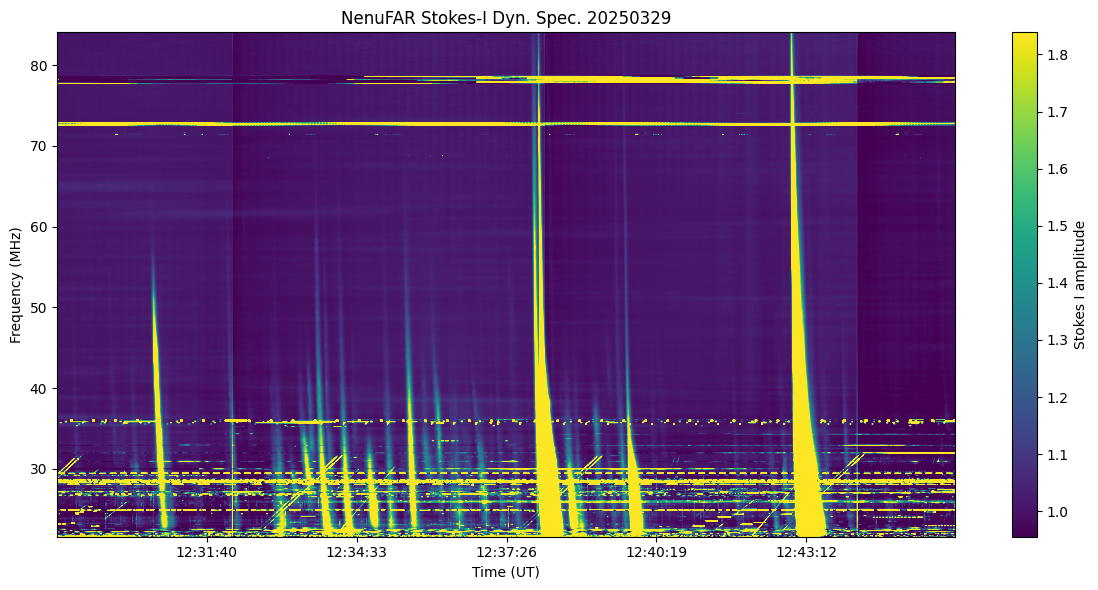

In [ ]:
# 1) Specify your observation date (YYYYMMDD) and output directory
date    = "20250329"
out_dir = "./saved_hdf5" # change your own pathway
os.makedirs(out_dir, exist_ok=True)

# Choose which Stokes parameters:
# stokes = ["I", "V", "V/I"]
stokes = ["I"]

# 2) Call the combiner:
#    - date:        YYYYMMDD string of observation
#    - output_dir:  directory to hold the low_0.hdf5, high_1.hdf5, and *_COM.hdf5 files
combined_h5 = combine_spectra(
    date                  = date,
    output_dir            = out_dir,
    stokes                = stokes,
    rebin_dt              = 0.1 * u.s,            # time rebinning interval
    rebin_df              = 60  * u.kHz,          # frequency rebinning interval
    tmin                  = "2025-03-29 12:28:48", # start time (UTC)
    tmax                  = "2025-03-29 12:46:04", # end time (UTC)
    force_reload          = True,                 # overwrite existing files
    normalization         = True,                 # enable sliding-window normalization
    normalization_type    = "median",             # "median" or "mean"
    normalization_threshold = 0.2,                # bottom 20% percentile
    normalization_window  = 1 * u.min,            # window size for normalization
    exclude_freq_range    = None,                 # list of (min,max) MHz to exclude
    show_dySp             = True                  # plot the dynamic spectrum
)

---

### **1.1 Load & Inspect Combined HDF5 Files**

This cell demonstrates how to read the low-band, high-band, and combined HDF5 files you just created. It uses our `load_combined_hdf5` tool to extract:

- **data3d**  `(ntime × nchan × 1)`  
  Raw dynamic spectrum array for a single Stokes parameter  
- **time_jd** `(ntime,)`  
  Julian Dates (UTC)  
- **time_unix** `(ntime,)`  
  UNIX timestamps (seconds since 1970-01-01)  
- **time_dt**  list of `datetime.datetime` (UTC) objects  
- **time_mpl** `(ntime,)`  
  Matplotlib “datenum” floats (days since 0001-01-01) for plotting  
- **freq**     `(nchan,)`  
  Frequency axis in MHz  

After loading, we squeeze off the singleton Stokes axis and transpose to `(frequency × time)` for producing quick‐look imaging.

The additional outputs (`time_mpl`, `time_dt`, `time_jd`, `freq`, etc.) provide fully-formatted time and frequency axes for axis labeling, zooming, and downstream analysis (e.g. window detection, fitting routines).  


In [ ]:
files = ["20250329_I_0.hdf5", "20250329_I_1.hdf5", "20250329_I_COM.hdf5", "20250329_I_responses.npz"]

import os
import urllib.request

if not os.path.exists('./data'):
    os.makedirs('./data')

for file in files:
    if not os.path.exists('./data/'+file):
        urllib.request.urlretrieve('https://a3s.fi/nenufar_sample/'+file, './data/'+file)

In [ ]:
# 1) Define file paths for low-band, high-band, and combined spectra
# Low-band only (21–59 MHz):
h5path_I_0 = "./data/20250329_I_0.hdf5" # This should be changed to the pathway on hub.
# High-band only (59–84 MHz):
h5path_I_1 = "./data/20250329_I_1.hdf5" # ...
# Wideband combined (21–84 MHz):
h5path_I_COM = "./data/20250329_I_COM.hdf5" # ...

# 2) Load each HDF5 file into memory, using load_combined_hdf5()
data3d_I_COM, time_jd_I_COM, time_unix_I_COM, time_dt_I_COM, time_mpl_I_COM, freq_I_COM = load_combined_hdf5(h5path_I_COM)
data3d_I_0,   time_jd_I_0,   time_unix_I_0,   time_dt_I_0,   time_mpl_I_0,   freq_I_0   = load_combined_hdf5(h5path_I_0)
data3d_I_1,   time_jd_I_1,   time_unix_I_1,   time_dt_I_1,   time_mpl_I_1,   freq_I_1   = load_combined_hdf5(h5path_I_1)

# 3) Squeeze off the singleton polarisation axis and transpose to (frequency × time)
# so that rows correspond to frequency channels and columns to time samples.
spec2d_I_0   = data3d_I_0.squeeze().T
spec2d_I_1   = data3d_I_1.squeeze().T
spec2d_I_COM = data3d_I_COM.squeeze().T

---

### **1.2 Quick-Look Dynamic Spectrum Visualization**

In this tutorial we’re using pre-loaded HDF5 files, so we’ll skip the on-server data retrieval (**step 1.0**).  
This cell creates a quick-look image of the **combined Stokes-I** dynamic spectrum, featuring:

1. **Robust color scaling** via the 5th/95th percentile of the entire dataset to suppress outliers.  
2. **Optional zoom** in time and frequency (uncomment or set `do_zoom=True`) for closer inspection.  
3. Proper **UT time formatting** on the x-axis and MHz on the y-axis.


In [ ]:
# -- Optional zoom window (set do_zoom=True) --
do_zoom = False

# define your zoom limits here:
t0 = datetime.strptime("2025-03-29 12:37:00", "%Y-%m-%d %H:%M:%S")
t1 = datetime.strptime("2025-03-29 12:44:06", "%Y-%m-%d %H:%M:%S")
t_start = date2num(t0);  t_end = date2num(t1)
f_min, f_max = 30.0, 80.0  # MHz

# -------------------------------------------------------
            # compute robust color‐limits
vmin, vmax = np.nanpercentile(spec2d_I_COM, [5, 95])

fig, ax = plt.subplots(figsize=(12,6))
im = ax.imshow(
    spec2d_I_COM,
    aspect='auto', origin='lower',
    extent=[time_mpl_I_COM[0], time_mpl_I_COM[-1], freq_I_COM[0], freq_I_COM[-1]],
    cmap='viridis', vmin=vmin, vmax=vmax
)
cbar = plt.colorbar(im, ax=ax, label=f"Stokes I amplitude")

ax.xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_title(f"NenuFAR Stokes-I DynSpec 2025-03-29")

if do_zoom:
    # apply zoom limits
    ax.set_xlim(t_start, t_end)
    ax.set_ylim(f_min, f_max)
    # recompute color‐limits on zoomed region
    time_idx = np.where((time_mpl_I_COM >= t_start) & (time_mpl_I_COM <= t_end))[0]
    freq_idx = np.where((freq_I_COM    >= f_min ) & (freq_I_COM    <= f_max))[0]
    sub_spec = spec2d_I_COM[np.ix_(freq_idx, time_idx)]
    vmin, vmax = np.nanpercentile(sub_spec, [5, 95])
    im.set_clim(vmin, vmax)
    cbar.mappable.set_clim(vmin, vmax)

plt.tight_layout()
plt.show()

---

### **1.3 Visualize Background Normalization Curve**

This cell reads the saved `.npz` file produced by `combine_spectra` and plots the final, per-channel response curve used to normalize Stokes–I:

1. **Load diagnostic `.npz`**  
   - `resp["freq"]` → full frequency axis (MHz)  
   - `resp["resp_percentX"]` → block-by‐block Xth-percentile curves, shape `(n_blocks, nbase, nchan)`  
2. **Collapse over time blocks**  
   - Take the median across all blocks: `collapsed = median(resp_percentX, axis=0)` → shape `(nbase, nchan)`  
3. **Select Stokes–I**  
   - We normalized only “I”, so extract `collapsed[0]` → `(nchan,)`  
4. **Optional frequency zoom**  
   - Apply a mask to focus on 25–75 MHz for clarity  
5. **Plot**  
   - Frequency (MHz) on the x-axis  
   - Applied response (arbitrary units) on the y-axis  


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Load
resp         = np.load("./data/20250329_I_responses.npz")
freq         = resp["freq"]           # (nchan,)
resp_percent = resp["resp_percentX"]  # (n_blocks, nbase, nchan)

# 2) collapse over blocks:
collapsed = np.nanmedian(resp_percent, axis=0)  # (nbase, nchan)

# 3) pick Stokes‐I (we only normalized I, so that's index 0):
final_resp = collapsed[0]                       # (nchan,)

# 4) zoom‐mask if desired:
mask      = (freq >= 25) & (freq <= 75)
freq_zoom = freq[mask]
resp_zoom = final_resp[mask]

# 5) plot
plt.figure(figsize=(8,4))
plt.plot(freq_zoom, resp_zoom, '-', lw=2)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Applied response (arb. units)")
plt.title("Final normalization curve (25–75 MHz)")
plt.xlim(25, 75)
plt.grid(True, ls=':')
plt.tight_layout()
plt.show()

---

### **1.4 Visualize Background‐Pixel Mask on Dynamic Spectrum**

This cell overlays the sliding‐window “background” pixels (those used for normalization) on top of the Stokes-I dynamic spectrum:

1. **Load the background mask** from the `.npz` diagnostics:  
   - `resp["background_mask"]` has shape `(nbase, ntime, nchan)`; index `[0]` for Stokes-I.  
2. **Transpose** the mask to match `spec2d` dimensions `(nfreq, ntime)`.  
3. **Extract pixel coordinates**  
   - `np.nonzero(mask_xy)` → arrays of frequency (`f_idx`) and time (`t_idx`) indices.  
   - Map indices to real values via `time_mpl_I_COM` and `freq`.  
4. **Quick‐look dynamic spectrum**  
   - Compute robust color limits (5th/95th percentile) on `spec2d_I_COM`.  
   - Use `imshow(..., vmin=vmin, vmax=vmax)` for consistent scaling.  
5. **Overlay background pixels** in red dots.  
6. **Optional zoom** in time/frequency by setting `do_zoom=True`.  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# assume the following are already in your namespace:
#   spec2d_I_COM   : 2D array (nfreq, ntime)
#   time_mpl_I_COM : 1D matplotlib datenums (ntime,)
#   freq     : 1D frequencies (nfreq,)
#   resp     : npz from combine_spectra, containing:
#              resp["background_mask"] of shape (ntime, nchan)

# reconstruct your mask & coords
bg_mask = resp["background_mask"][0]   # shape (ntime, nchan)
# note: spec2d is (freq, time), so transpose mask:
mask_xy = bg_mask.T                # now (nfreq, ntime)

# get pixel indices
f_idx, t_idx = np.nonzero(mask_xy)
t_vals = time_mpl_I_COM[t_idx]
f_vals = freq   [f_idx]

# optional zoom
do_zoom = False

if do_zoom:
    from datetime import datetime
    from matplotlib.dates import date2num
    t0 = datetime.strptime("2025-03-29 12:37:00", "%Y-%m-%d %H:%M:%S")
    t1 = datetime.strptime("2025-03-29 12:44:06", "%Y-%m-%d %H:%M:%S")
    t_start, t_end = date2num(t0), date2num(t1)
    f_min, f_max   = 30.0, 80.0

# plot
fig, ax = plt.subplots(figsize=(12, 6))
vmin, vmax = np.nanpercentile(spec2d_I_COM, [5, 95])
im = ax.imshow(
    spec2d_I_COM,
    aspect='auto',
    origin='lower',
    extent=[time_mpl_I_COM[0], time_mpl_I_COM[-1], freq[0], freq[-1]],
    cmap='viridis',
    vmin=vmin,
    vmax=vmax
)
cbar = plt.colorbar(im, ax=ax, label='Stokes I amplitude')

# overlay background‐pixels
ax.scatter(t_vals, f_vals, s=8, c='red', alpha=0.6, label='Background pixels')

# apply zoom if desired
if do_zoom:
    ax.set_xlim(t_start, t_end)
    ax.set_ylim(f_min, f_max)

# formatting
ax.xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
ax.set_xlabel("Time (UT)")
ax.set_ylabel("Frequency (MHz)")
ax.set_title("Dynamic Spectrum with Background‐pixel Mask")
ax.legend(loc='upper right', fontsize='small')
plt.tight_layout()
plt.show()

---

## Part 2 – Defining Regions of Interest (ROI) for Type III Bursts

This cell is the only one in **Part 2**. It lets you pick a time–frequency window around your Type III burst by running our `detect_window` routine to:

1. **Extract** the sub‐spectrum inside your chosen ROI.  
2. **Compute** per‐channel peak times and frequencies.  
3. **(Optional)** Plot:
   - If `peak_drift=True`, overlay the peak‐time markers on the dynamic spectrum.  
   - If `peak_drift=False`, show the dynamic‐spectrum window without any peaks.  
4. **Customize Y‐axis scaling** via `y_scale="linear"` or `"inverse"` to plot frequency in MHz or 1/MHz.  
5. **Return** a dictionary containing:  
   - `roi_data`, `roi_time_mpl`, `roi_freq_values` → the sliced dynamic spectrum  
   - `peak_times`, `peak_freqs` → arrays of flux‐peak times and frequencies  

These returned values feed directly into Part 3 routines for time‐profile fitting and exciter‐velocity analysis of your selected Type III burst.  

In [ ]:
# 1) Define your ROI in UTC
t0 = datetime(2025, 3, 29, 12, 42, 53)
t1 = datetime(2025, 3, 29, 12, 43,  9)
t_start = date2num(t0)
t_end   = date2num(t1)

# 2) Run detection & show plots
results = detect_window(
    data3d      = data3d_I_COM,    # (ntime, nfreq, 1)
    time_mpl    = time_mpl_I_COM,  # Matplotlib‐date time axis
    freq_values = freq_I_COM,      # MHz axis
    t_start_mpl = t_start,
    t_end_mpl   = t_end,
    f_min       = 20,              # MHz low‐end
    f_max       = 70,              # MHz high‐end
    show        = True,
    y_scale     = "linear",       # "linear" or "inverse"
    peak_drift  = False             # Show peak of each frequency chennel or not
)

# 3) Unpack ROI & peaks
sub_I      = results["roi_data"]         # (ntime_roi, nchan_roi, 1)
t_sub      = results["roi_time_mpl"]     # (ntime_roi,)
f_sub      = results["roi_freq_values"]  # (nchan_roi,)
peak_times = results["peak_times"]       # (nchan_roi_after_drop,)
peak_freqs = results["peak_freqs"]

---
> 💡 Now that you’ve peeked at the full-band dynamic spectrum in **Cell 1.2**, pick out a Type III burst that catches your eye—note its approximate start and end times in UT.  
>  
> ▶️ **Next**, use the cell above (Part 2) to carve out a **Region of Interest (ROI)** around your chosen burst.  
>  
> 🔄 You can toggle `do_zoom` or adjust `t_start_mpl`, `t_end_mpl`, `f_min` and `f_max` to fine-tune exactly where the burst lives in time and frequency.  
>  
> 🕒 **Practice Exercise**: At the end of this notebook you’ll find three suggested UT time-windows for three different bursts. Try applying the same workflow to each one, so you get comfortable defining ROIs for Type III bursts in NenuFAR data.
---

## Part 3 – Time‐Profile Fitting & Exciter Velocity Estimation

### **3.1 Multi‐Model Fitting of Burst Time Profiles**

In this section we take your ROI from Part 2 and:

1. **Build light curves** by averaging over narrow frequency sub‐bands (or one per channel if `per_channel=True`).  
2. **Fit multiple models** (exponential, Gaussian, bi‐Gaussian, Chrysaphi) to each light curve.  (`show_fitplot=True`)
3. **Pick the best model** by χ² test, then compute start/end times via your chosen `fit_method` (`"FWHM"` or `"1/e"`).  
4. **Report** rise‐time (start→peak) and decay‐time (peak→end) in seconds, and indicate which model was used for each.  
5. **Draw** a small diagnostic plot showing the data, all model curves, and dashed lines at start/peak/end times with proper UTC labeling.

> 💡 **Tip:** This example uses a single **0.1 MHz** band around **60 MHz**.  
> - To explore other frequency regions, modify the `frequency_ranges` list.  
> - Set `per_channel=True` to fit *each* channel individually (useful for narrow‐band studies).  
> 
> ⚠️ **Warning:** Enabling `per_channel=True` over a broad band or at full NenuFAR resolution can be very slow or may exhaust memory, as it performs and plots one fit per channel.

In [ ]:
# Extract the ROI dynamic spectrum and drop the singleton Stokes axis → shape (ntime_roi, nfreq_roi)
roi_data = results['roi_data'].squeeze()

# Convert ROI time axis from Matplotlib datenums to seconds since ROI start
roi_time = (results['roi_time_mpl'] - results['roi_time_mpl'][0]) * 86400

# Grab the ROI frequency axis in MHz
roi_freq = results['roi_freq_values']

# Run the multi-model fit on each specified freq. band (here 60.00–60.10 MHz)
out = fit_roi_time_profiles(
    roi_data,                   # dynamic spectrum array (ntime_roi × nfreq_roi)
    roi_time,                   # time axis in seconds (ntime_roi,)
    roi_freq,                   # frequency axis in MHz (nfreq_roi,)
    frequency_ranges=[(60, 60.1)],  # list of (fmin, fmax) tuples defining sub-bands
    per_channel=False,          # average across each 0.1 MHz block instead of per-channel
    show_fitplot=True,          # show diagnostic plots of data + all model curves
    fit_method="FWHM",           # define burst start/end at half of peak amplitude, or "1/e" that at 1/e of peak amplitude.
    sigma=None,                 # no uncertainty weighting in χ² calculation
    chi_definition='reduced',   # use reduced χ² for model selection
    window_start_mpl=results['roi_time_mpl'][0]  
                                # MPL date of ROI start → for UTC label on X-axis
                                # ensure the X‐axis label shows the correct UTC
)

---

### **3.2 Burst Frequency Drift & Exciter Velocity Analysis**

This cell takes the ROI you defined in Part 2 and computes both the frequency drift of the burst and, using a coronal density model, converts that drift into an exciter (electron‐beam) velocity.  

**What it does:**  
1. **Peak‐time curve fitting**  
   - For each frequency channel (or band), fits the time‐profile with your chosen model (e.g. bi‐Gaussian). 
   - Extracts the channel‐by‐channel **start**, **peak**, and **end** times.
2. **Drift‐rate estimation**  
   - Computes the **average linear drift** (df/dt) via linear fitting of time-frequency profile of the peak fux.  
   - Fits a **non‐linear power-law** form \(\frac{df}{dt}=-k\,f^\alpha\) to the instantaneous drift estimates.  
3. **Density‐model conversion**  
   - Adopts your selected coronal density model (e.g. “saito”) and emission mechanism (“F” for fundamental) to translate df/dt into beam speed \(v/c\).  
   - In the source code, you can add your own interested coronal density modes.
4. **Visualization**  
   - **Top panel:** the ROI dynamic spectrum with vertical lines marking the fitted **start**, **peak**, and **end** times.  
   - **Middle panel:** scatter of peak‐time vs. peak‐frequency overlaid with  
     - the **linear drift** line and  
     - the **power‐law drift** curve.  
   - **Bottom panel:** inferred **radial height** (from your density model) vs. time, with separate linear fits to the **front**, **peak**, and **back** of the exciter, yielding three velocity estimates.

In [ ]:
analyze_burst_velocity(
    burst_data        = results,           # Output dict from detect_window (Part 2)
    density_model     = "saito",           # Ambient coronal electron density model
    emission_mechanism= "F",               # "F" = fundamental, "H" = harmonic
    # freq_range      = (20,70),            # Optionally restrict channels for analysis
    fit_method        = "FWHM",            # How to define start/end widths, similar to what we practiced in fit_roi_time_profiles()
    y_scale           = "linear",          # "linear" or "inverse" frequency axis, similar to what we practiced in detect_window()
    fit_mode          = "biGaussian",      # Model you selected for fitting time profile
    show_drift_panel=False,                # Show “Frequency Drift Over Time” panel or not
    show_density_models=False              # Overlay density model curves
)

### **Practice: Defining ROIs for Additional Bursts**
---
> 🕒 **Practice Exercise**: Try defining ROIs around each of two burst time (tools in Part 1 and 2), then to extract time-profiles and compute the electron-beam velocities (Parts 3.1 and 3.2):
> 
> 1. **12:38:10 UT** 
> 2. **12:37:55 UT**  
> 3. **12:30:45 UT**  
---